# PSO-LSTMによる株価指数の終値予測（5分足）

このノートブックは、論文「Enhancing stock index prediction: A hybrid LSTM-PSO model for improved forecasting accuracy」に基づき、
PSOでLSTMのハイパーパラメータを最適化し、次時点の終値（close）を予測します。

- データ: yfinance（5分足）
- ルックバック: 5分 / 30分 / 60分
- マクロ指標: USD/JPY、金利（^IRX）
- 評価指標: RMSE / MAE / MAPE / R2

> 注意: 5分足データは取得可能期間が短いです。必要に応じて期間を調整してください。


In [ ]:
import warnings

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns
# 日本語フォントの設定
try:
    import japanize_matplotlib
    print("japanize_matplotlib を使用して日本語フォントを設定しました")
except ImportError:
    # japanize_matplotlibが利用できない場合の代替設定
    plt.rcParams['font.family'] = ['DejaVu Sans', 'Hiragino Sans', 'Yu Gothic', 'Meiryo', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
    print("代替フォント設定を使用しました")
sns.set_theme(font="IPAexGothic")

warnings.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)

# GPUがある場合はメモリ成長を有効化。複数GPUの場合は MirroredStrategy でデータ並列
physical_gpus = tf.config.list_physical_devices("GPU")
print(tf.config.list_physical_devices("GPU"))
if physical_gpus:
    for gpu in physical_gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU利用: {len(physical_gpus)}台")
    if len(physical_gpus) > 1:
        strategy = tf.distribute.MirroredStrategy()
        print(f"複数GPUモード: MirroredStrategy で {strategy.num_replicas_in_sync} 台を使用")
    else:
        strategy = None
else:
    print("GPUなし: CPUで実行します")
    strategy = None


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU利用: 1台


In [ ]:
from pso_lstm_common import (
    BATCH_SIZE,
    NEURON_BOUNDS,
    EPOCH_BOUNDS,
    LAYER_BOUNDS,
    PSO_W,
    PSO_C1,
    PSO_C2,
    PSO_PARTICLES,
    PSO_ITERS,
    add_technical_indicators,
    build_lstm_model,
    build_target_return,
    compute_metrics,
    create_sequences,
    download_macro_daily,
    download_price_data,
    merge_macro_features,
    pso_optimize,
    remove_high_corr_features,
    resample_ohlcv,
    resample_series,
    scale_train_val_test,
    train_val_test_split,
    wavelet_denoise,
)

In [ ]:
# ===== 設定 =====
INDEX_TICKERS = ["^GSPC"]  # 例: S&P500
FX_TICKER = "USDJPY=X"
RATE_TICKER = "^IRX"  # 米国短期金利（代替指標）

BASE_INTERVAL = "5m"
BASE_PERIOD = "60d"  # 5分足の取得可能期間に合わせる

RESAMPLE_MINUTES = [5, 30, 60]
LOOKBACK_STEPS = {
    5: 5,    # 5分足 -> 5ステップ
    30: 30,  # 30分足 -> 30ステップ
    60: 60,  # 60分足 -> 60ステップ
}

TRAIN_RATIO = 0.8
VAL_RATIO = 0.2

print("設定完了")


設定完了


- 論文: 粒子の速度範囲は [–2, 2]。
- コード: 明示的な設定なし。
  - pyswarms のGlobalBestPSO に options で c1, c2, w だけ渡しており、速度の clamp（v_max 等）は指定していません。論文に合わせる場合は、pyswarms で速度制限を指定できるか API を確認し、あれば追加する必要があります。

In [ ]:
results = []
plot_data = []  # 別セクションで可視化する用

for ticker in INDEX_TICKERS:
    print(f"\n=== {ticker} ===")
    base_price = download_price_data(ticker, BASE_INTERVAL, BASE_PERIOD)

    try:
        fx_5m = download_price_data(FX_TICKER, BASE_INTERVAL, BASE_PERIOD)["close"]
    except Exception:
        fx_5m = download_macro_daily(FX_TICKER)

    rate_daily = download_macro_daily(RATE_TICKER)

    for minutes in RESAMPLE_MINUTES:
        print(f"--- {minutes}分足 ---")
        df = resample_ohlcv(base_price, minutes)
        df["close"] = wavelet_denoise(df["close"], level=3)

        df = add_technical_indicators(df)

        fx_resampled = resample_series(fx_5m, minutes)
        df = merge_macro_features(df, fx_resampled, rate_daily)

        df["target_return"] = build_target_return(df)
        df = df.dropna()

        feature_df, dropped = remove_high_corr_features(df, target_col="target_return")
        df_final = feature_df.copy()

        feature_cols = [c for c in df_final.columns if c != "target_return"]
        features = df_final[feature_cols].values
        target = df_final["target_return"].values

        lookback = LOOKBACK_STEPS[minutes]
        close_col_idx = feature_cols.index("close")
        X, y, last_close = create_sequences(features, target, lookback, close_col_idx=close_col_idx)

        (
            X_train,
            y_train,
            X_val,
            y_val,
            X_test,
            y_test,
            last_close_train,
            last_close_val,
            last_close_test,
        ) = train_val_test_split(
            X, y, train_ratio=TRAIN_RATIO, val_ratio=VAL_RATIO, last_close=last_close
        )

        X_train_s, X_val_s, X_test_s, y_train_s, y_val_s, y_test_s, x_scaler, y_scaler = scale_train_val_test(
            X_train, X_val, X_test, y_train, y_val, y_test
        )

        input_shape = (X_train_s.shape[1], X_train_s.shape[2])

        pso_csv_path = f"pso_log_{ticker.replace('^', '')}_{minutes}m.csv"
        best_pos, best_cost = pso_optimize(
            X_train_s, y_train_s, X_val_s, y_val_s, input_shape, csv_log_path=pso_csv_path,
            batch_size=BATCH_SIZE, neuron_bounds=NEURON_BOUNDS, epoch_bounds=EPOCH_BOUNDS,
            layer_bounds=LAYER_BOUNDS, pso_w=PSO_W, pso_c1=PSO_C1, pso_c2=PSO_C2,
            pso_particles=PSO_PARTICLES, pso_iters=PSO_ITERS,
            strategy=strategy,
        )
        best_units = int(np.clip(round(best_pos[0]), *NEURON_BOUNDS))
        best_epochs = int(np.clip(round(best_pos[1]), *EPOCH_BOUNDS))
        best_layers = int(np.clip(round(best_pos[2]), *LAYER_BOUNDS))

        tf.keras.backend.clear_session()
        if strategy is not None:
            with strategy.scope():
                final_model = build_lstm_model(input_shape, best_layers, best_units)
        else:
            final_model = build_lstm_model(input_shape, best_layers, best_units)

        # 最終学習用コールバック: EarlyStopping と ModelCheckpoint
        early_stopping = keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=30,
            restore_best_weights=True,
        )
        ckpt_path = f"best_model_{ticker.replace('^', '')}_{minutes}m.keras"
        model_checkpoint = keras.callbacks.ModelCheckpoint(
            ckpt_path,
            monitor="val_loss",
            save_best_only=True,
        )
        csv_logger = keras.callbacks.CSVLogger(f"final_log_{ticker.replace('^', '')}_{minutes}m.csv")

        X_fit = np.concatenate([X_train_s, X_val_s])
        y_fit = np.concatenate([y_train_s, y_val_s])
        history = final_model.fit(
            X_fit,
            y_fit,
            validation_split=0.2,
            epochs=best_epochs,
            batch_size=BATCH_SIZE,
            verbose=0,
            callbacks=[early_stopping, model_checkpoint, csv_logger],
        )

        pred_scaled = final_model.predict(X_test_s, verbose=0)
        pred_return = y_scaler.inverse_transform(pred_scaled).reshape(-1)
        # 騰落率→終値に復元（グラフは縦軸を終値で表示）
        y_pred_close = last_close_test * (1 + pred_return)
        y_true_close = last_close_test * (1 + y_test)

        rmse, mae, mape, r2 = compute_metrics(y_true_close, y_pred_close)

        plot_data.append({
            "ticker": ticker,
            "minutes": minutes,
            "y_true": y_true_close.copy(),
            "y_pred": y_pred_close.copy(),
            "history": history,
        })

        results.append(
            {
                "ticker": ticker,
                "minutes": minutes,
                "lookback": lookback,
                "units": best_units,
                "epochs": best_epochs,
                "layers": best_layers,
                "rmse": rmse,
                "mae": mae,
                "mape": mape,
                "r2": r2,
                "dropped_features": dropped,
            }
        )

        print(
            f"units={best_units}, epochs={best_epochs}, layers={best_layers} | "
            f"RMSE={rmse:.6f}, MAE={mae:.6f}, MAPE={mape:.4f}, R2={r2:.4f}"
        )

results_df = pd.DataFrame(results)
results_df



=== ^GSPC ===


--- 5分足 ---
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2026-02-05 05:56:28,527 - tensorflow - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2026-02-05 05:56:28,531 - tensorflow - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2026-02-05 05:56:28,698 - tensorflow - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2026-02-05 05:56:28,702 - tensorflow - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 05:56:29,274 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
2026-02-05 05:56:30.558098: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91900
2026-02-05 05:56:31.145627: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91900


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2026-02-05 05:56:32.951893: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2026-02-05 05:56:32.951972: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2026-02-05 05:56:32.952028: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2026-02-05 05:56:33,103 - tensorflow - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2026-02-05 05:56:33,106 - tensorflow - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2026-02-05 05:56:33,260 - tensorflow - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2026-02-05 05:56:33,262 - tensorflow - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2026-02-05 05:56:33,302 - tensorflow - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2026-02-05 05:56:33,304 - tensorflow - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2026-02-05 05:56:34.210212: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2026-02-05 05:56:35.661851: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2026-02-05 05:56:38.755068: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2026-02-05 05:56:45.019484: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 05:56:50,562 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
2026-02-05 05:56:59.971477: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


INFO:tensorflow:Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 05:57:04,048 - tensorflow - INFO - Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 05:57:15,740 - tensorflow - INFO - Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
2026-02-05 05:57:24.414026: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


INFO:tensorflow:Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 05:57:30,060 - tensorflow - INFO - Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 05:57:47,943 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 05:58:05,816 - tensorflow - INFO - Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 05:58:24,461 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
2026-02-05 05:58:29.445772: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 05:58:40,247 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 05:58:56,195 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 05:59:11,984 - tensorflow - INFO - Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 05:59:26,138 - tensorflow - INFO - Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 05:59:40,238 - tensorflow - INFO - Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 05:59:51,672 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:00:07,112 - tensorflow - INFO - Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
2026-02-05 06:00:15.802353: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


INFO:tensorflow:Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:00:17,436 - tensorflow - INFO - Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:00:30,520 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:00:49,448 - tensorflow - INFO - Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:01:02,257 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:01:18,170 - tensorflow - INFO - Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:01:30,914 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


units=211, epochs=94, layers=2 | RMSE=107.174121, MAE=102.307270, MAPE=1.4748, R2=-5.7839
--- 30分足 ---
INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:01:53,646 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:02:02,648 - tensorflow - INFO - Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:02:24,245 - tensorflow - WARNING - 5 out of the last 32 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f75bc1927a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2026-02-05 06:02:24,511 - tensorflow - WARNING - 6 out of the last 35 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f75bc1927a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


INFO:tensorflow:Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:02:26,557 - tensorflow - INFO - Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:02:37,887 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:02:53,069 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:03:01,539 - tensorflow - INFO - Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
2026-02-05 06:03:13.172405: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:03:16,943 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:03:38,625 - tensorflow - INFO - Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:03:55,607 - tensorflow - INFO - Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:04:11,560 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:04:26,051 - tensorflow - INFO - Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:04:43,840 - tensorflow - INFO - Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:04:54,595 - tensorflow - INFO - Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:05:13,963 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:05:24,742 - tensorflow - INFO - Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:05:40,534 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:05:58,282 - tensorflow - INFO - Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:06:16,011 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:06:40,238 - tensorflow - INFO - Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:06:56,731 - tensorflow - INFO - Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:07:05,587 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


units=207, epochs=224, layers=2 | RMSE=69.527629, MAE=60.645959, MAPE=0.8732, R2=-3.2123
--- 60分足 ---
INFO:tensorflow:Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:07:18,977 - tensorflow - INFO - Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:07:27,476 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:07:36,951 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:07:45,389 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:07:54,635 - tensorflow - INFO - Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:08:02,369 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:08:11,096 - tensorflow - INFO - Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
2026-02-05 06:08:14.635841: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:08:22,439 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:08:31,540 - tensorflow - INFO - Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:08:39,592 - tensorflow - INFO - Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:08:49,099 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:08:58,292 - tensorflow - INFO - Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:09:05,898 - tensorflow - INFO - Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:09:13,745 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:09:22,883 - tensorflow - INFO - Collective all_reduce tensors: 11 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:09:31,951 - tensorflow - INFO - Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:09:39,757 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:09:48,415 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:09:58,270 - tensorflow - INFO - Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:10:07,592 - tensorflow - INFO - Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2026-02-05 06:10:15,350 - tensorflow - INFO - Collective all_reduce tensors: 5 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


units=53, epochs=216, layers=1 | RMSE=62.410371, MAE=53.387352, MAPE=0.7680, R2=-3.6617


,ticker,minutes,lookback,units,epochs,layers,rmse,mae,mape,r2,dropped_features
0,^GSPC,5,5,211,94,2,107.174121,102.307270,1.474816,-5.783908,"[adj close_^gspc, close_^gspc, high_^gspc, low..."
1,^GSPC,30,30,207,224,2,69.527629,60.645959,0.873231,-3.212344,"[open, high, low, close, ema20, ma5, ma10]"
2,^GSPC,60,60,53,216,1,62.410371,53.387352,0.768000,-3.661694,"[open, high, low, close, ma5, ma10]"


## ベストモデルの可視化

最終モデル学習後、各足（5分/30分/60分）について以下を表示します。
- ベストモデルで推論した結果（実測 vs 予測）
- Epoch と Loss の推移

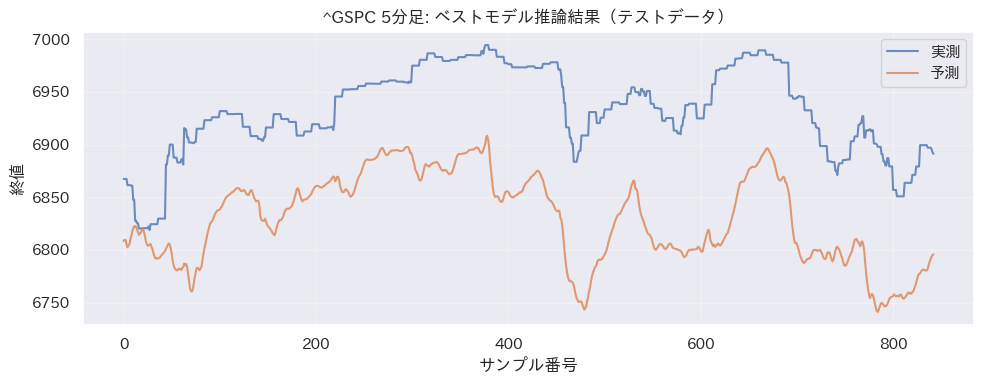

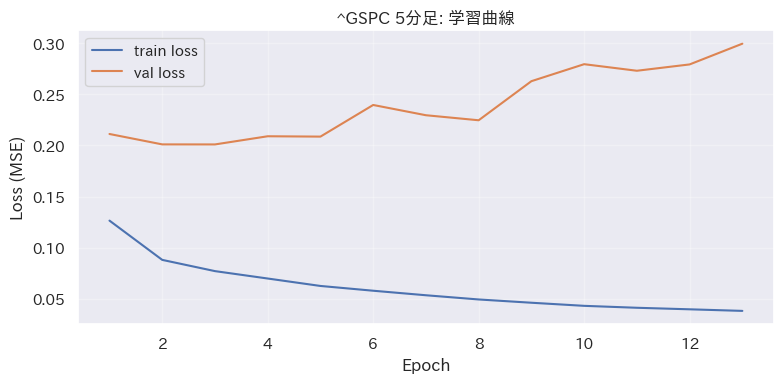

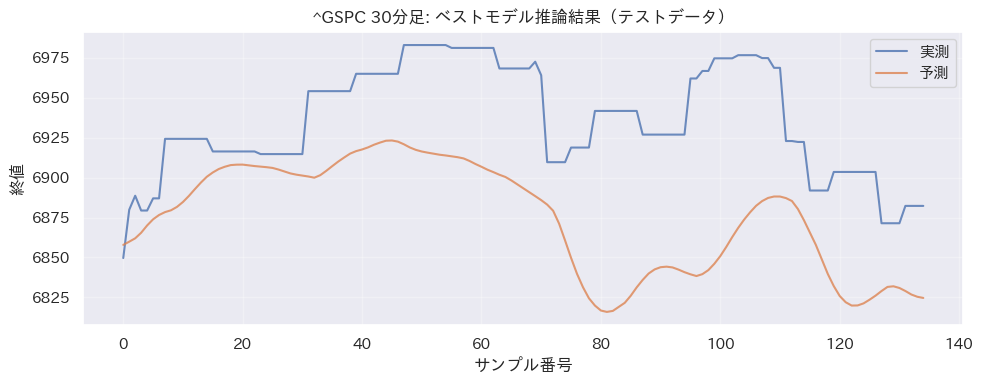

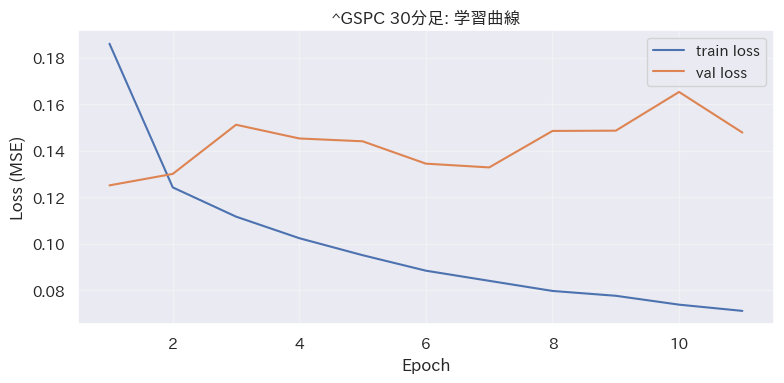

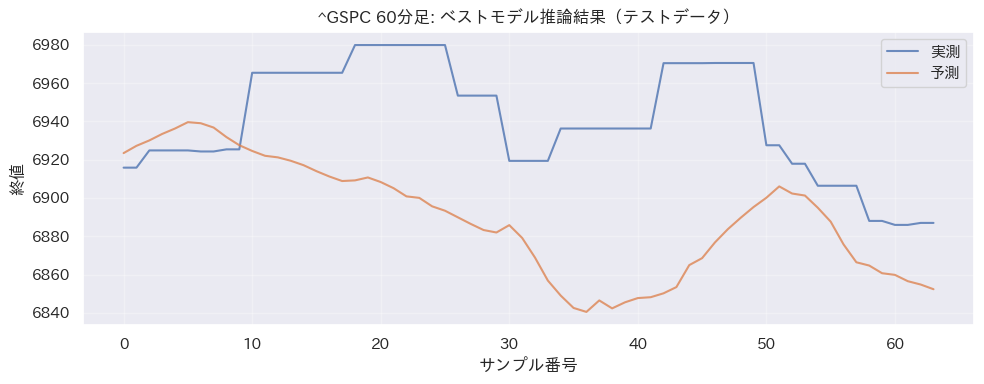

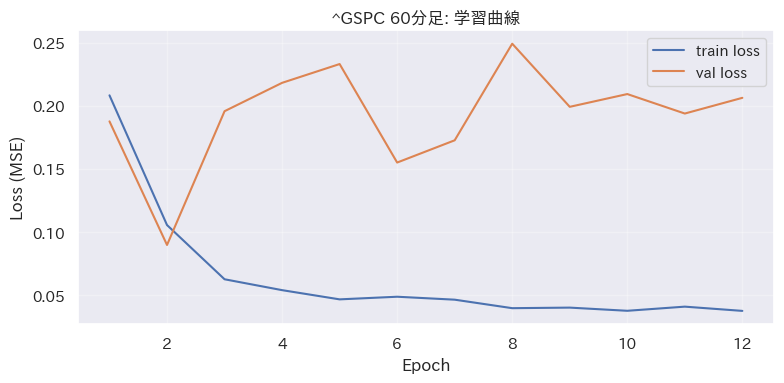

In [5]:
for d in plot_data:
    ticker, minutes = d["ticker"], d["minutes"]
    y_true, y_pred = d["y_true"], d["y_pred"]
    history = d["history"]

    # ベストモデルの推論結果（実測 vs 予測）
    fig, ax = plt.subplots(figsize=(10, 4))
    x_idx = np.arange(len(y_true))
    ax.plot(x_idx, y_true, label="実測", alpha=0.8)
    ax.plot(x_idx, y_pred, label="予測", alpha=0.8)
    ax.set_xlabel("サンプル番号")
    ax.set_ylabel("終値")
    ax.set_title(f"{ticker} {minutes}分足: ベストモデル推論結果（テストデータ）")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Epoch と Loss の推移
    fig, ax = plt.subplots(figsize=(8, 4))
    epochs_range = range(1, len(history.history["loss"]) + 1)
    ax.plot(epochs_range, history.history["loss"], label="train loss")
    if "val_loss" in history.history:
        ax.plot(epochs_range, history.history["val_loss"], label="val loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss (MSE)")
    ax.set_title(f"{ticker} {minutes}分足: 学習曲線")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [6]:
results_df = results_df.sort_values(["ticker", "minutes"]).reset_index(drop=True)
results_df


,ticker,minutes,lookback,units,epochs,layers,rmse,mae,mape,r2,dropped_features
0,^GSPC,5,5,211,94,2,107.174121,102.307270,1.474816,-5.783908,"[adj close_^gspc, close_^gspc, high_^gspc, low..."
1,^GSPC,30,30,207,224,2,69.527629,60.645959,0.873231,-3.212344,"[open, high, low, close, ema20, ma5, ma10]"
2,^GSPC,60,60,53,216,1,62.410371,53.387352,0.768000,-3.661694,"[open, high, low, close, ma5, ma10]"
